### Dobule Descent in Gradient Boosting

In [3]:
! pip install pandas matplotlib scikit-learn

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

In [5]:
susceptible_dir = "/home/jovyan/DOUBLE_DESCENT/Data/downloaded_susceptible/gunziped_susceptible/csv_susceptible/post_QC_susceptible"

In [6]:
resistant_dir = "/home/jovyan/DOUBLE_DESCENT/Data/downloaded_resistant/gunziped_resistant/csv_converted/post_QC_resistant"

In [7]:
# Extract genotype features
def extract_features_from_csv(file_path):
    df = pd.read_csv(file_path)
    
    # Separate GT and the other fields from col[-1]
    sample_col = df.columns[-1]
    df[["GT", "DP", "GT_CONF"]] = df[sample_col].str.split(":", expand=True) [[0, 1, 5]]
    
    # Convert GT to numeric
    genotype_map = {"0/0": 0, "0/1": 1, "1/1": 2}
    df["GT"] = df["GT"].map(genotype_map).fillna(0).astype(int)
    
    # Convert DP and GT_CONF to float
    df["DP"] = pd.to_numeric(df["DP"], errors="coerce").fillna(0)
    df["GT_CONF"] = pd.to_numeric(df["GT_CONF"], errors="coerce").fillna(0)
    
    return df[["POS", "GT", "DP", "GT_CONF"]]

In [8]:
# Load susceptible samples
susceptible_data = []
for file in os.listdir(susceptible_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(susceptible_dir, file)
        susceptible_data.append(extract_features_from_csv(file_path))
susceptible_df = pd.concat(susceptible_data, ignore_index=True)
susceptible_df["label"] = 0

In [9]:
# Load all resistant samples
resistant_data = []
for file in os.listdir(resistant_dir):
    if file.endswith(".csv"):
        file_path = os.path.join(resistant_dir, file)
        resistant_data.append(extract_features_from_csv(file_path))
resistant_df = pd.concat(resistant_data, ignore_index=True)
resistant_df["label"] = 1

In [10]:
# Merge datasets
data = pd.concat([susceptible_df, resistant_df], ignore_index=True)

In [12]:
data.shape

(765413, 5)

In [13]:
data.head(n=5)

,POS,GT,DP,GT_CONF,label
0,1849,2,318,2441.45,0
1,1977,2,303,2369.32,0
2,4013,2,352,2660.17,0
3,7362,2,295,2321.12,0
4,7585,2,322,2482.97,0


In [15]:
data.isna().sum()

POS        0
GT         0
DP         0
GT_CONF    0
label      0
dtype: int64

In [20]:
print(list(data["label"].unique()))

[np.int64(0), np.int64(1)]


In [17]:
# Drop NaNs (if any) - just in case
data.dropna(inplace=True)

In [21]:
# Prepare training and test data
X = data.drop(columns=["label"])

In [22]:
y = data["label"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
# Train Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [25]:
# Predictions
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

In [26]:
# Compute Errors
train_error = mean_squared_error(y_train, y_train_pred)

In [27]:
test_error = mean_squared_error(y_test, y_test_pred)

In [28]:
# Compute Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

In [29]:
print(f"Training Error: {train_error:.4f}, Test Error: {test_error:.4f}")
print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Training Error: 0.0993, Test Error: 0.0997
Training Accuracy: 0.9007, Test Accuracy: 0.9003


In [30]:
# Experiment: Varying number of boosting rounds
n_estimators_range = list(range(10, 300, 20))
train_errors = []
test_errors = []

In [31]:
for n in n_estimators_range:
    gb = GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, max_depth=3, random_state=42)
    gb.fit(X_train, y_train)
    
    y_train_pred = gb.predict(X_train)
    y_test_pred = gb.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

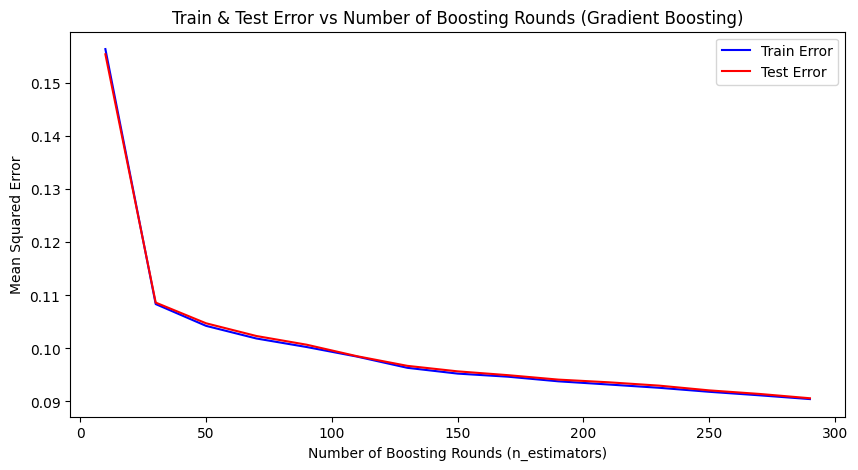

In [32]:
# Visualisation
plt.figure(figsize=(10, 5))
plt.plot(n_estimators_range, train_errors, label="Train Error", color="blue")
plt.plot(n_estimators_range, test_errors, label="Test Error", color="red")
plt.xlabel("Number of Boosting Rounds (n_estimators)")
plt.ylabel("Mean Squared Error")
plt.title("Train & Test Error vs Number of Boosting Rounds (Gradient Boosting)")
plt.legend()
plt.show()